# Cлучайный лес в реальной задаче

Для этого будем использовать пример с задачей fraud detection. Это задача классификации, поэтому будем использовать метрику accuracy для оценки точности. Для начала построим самый простой классификатор, который будет нашим бейслайном. Возьмем только числовые признаки для упрощения.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Загружаем данные
df = pd.read_csv("/Users/iakubovskii/Machine_Learning/RANEPA/Fintech_2020/Анализ данных/Данные/telecom_churn.csv")

# Выбираем сначала только колонки с числовым типом данных
cols = []
[cols.append(i) for i in df.columns if (df[i].dtype == "float64") or (df[i].dtype == 'int64')]
        
# Разделяем на признаки и объекты
X, y = df[cols], df["Churn"].values

# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем точность на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 92.50%


Получили точность 92.5%, теперь попробуем улучшить этот результат и посмотреть, как ведут себя кривые обучения при изменении
основных параметров.

Начнем с количества деревьев:

In [4]:
import warnings
warnings.filterwarnings("ignore")
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [100, 150, 200, 250]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100 trees


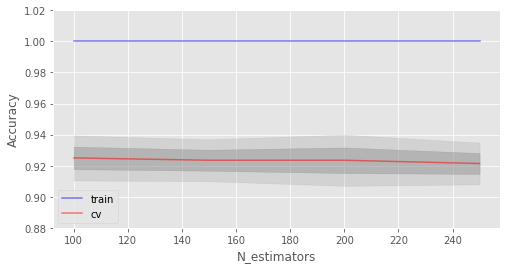

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

На рисунке видно, что при увеличении количества деревьев, наша точность модели на кросс-валидации немного снижается. Также видим, что на тренировочной выборке мы достигаем 100% точности, это говорит нам о переобучении нашей модели. Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель.

Начнем с параметра максимальной глубины – `max_depth`. (зафиксируем к-во деревьев 100)

Best accuracy on CV is 92.44% with 24 max_depth


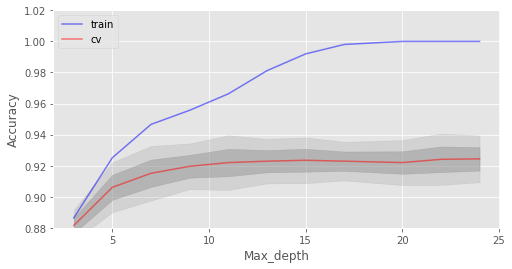

In [6]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр `max_depth` хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. Точность нашей модели немного возросла.

Еще важный параметр `min_samples_leaf`, он так же выполняет функцию регуляризатора.


In [7]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 1 min_samples_leaf


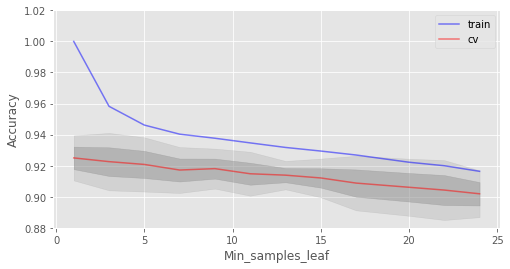

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение до 2% при сохранении точности около 90%.

Рассмотрим такой параметр как `max_features`. Для задач классификации по умолчанию используется $\large \sqrt{n}$, где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признака или нет.


Best accuracy on CV is 92.50% with 4 max_features


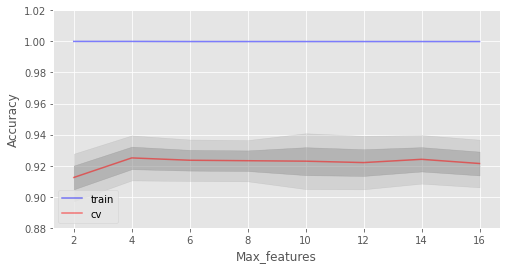

In [9]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

В нашем случае оптимальное число признаков — 4, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров. Давайте теперь с помощью `GridSearch` найдем оптимальные параметры для нашего примера.

In [10]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

gcv.best_estimator_, gcv.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


(RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True, random_state=42),
 0.925596661128895)

In [11]:
# Важность признаков
rf_best = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True,
                                max_features = 10, max_depth=20, min_samples_leaf=3)
rf_best.fit(X, y)

pd.DataFrame(dict(zip(X.columns, rf_best.feature_importances_)), index=[0]).T.sort_values(0, ascending=False)

,0
Total day charge,0.174484
Total day minutes,0.153635
Customer service calls,0.136789
Total eve minutes,0.096544
Total eve charge,0.084627
Number vmail messages,0.076970
Total night minutes,0.038495
Total night charge,0.034747
Total night calls,0.032939
Account length,0.031517


# Бустинг

## CatBoost

In [12]:
# CatBoost classifier

from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

X, y = load_wine()['data'], load_wine()['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

feature_wine = load_wine()['feature_names']
print(pd.DataFrame(X_train, columns = feature_wine).nunique())

print("Categorical features are absent in this dataset")

from catboost import CatBoostClassifier, Pool

# initialize Pool
train_pool = Pool(X_train, 
                  label = y_train, 
                  cat_features=None)

test_pool = Pool(X_test, 
                 label = y_test,
                 cat_features=None)

model = CatBoostClassifier(iterations=5,
                           depth=5,
                           learning_rate=0.3,
                           loss_function='MultiClass',
                           verbose=True)
# train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
print("class = ", preds_class[:5])
print("proba = \n", preds_proba[:5])
print(confusion_matrix(y_test, preds_class))

alcohol                         110
malic_acid                      111
ash                              74
alcalinity_of_ash                57
magnesium                        50
total_phenols                    88
flavanoids                      110
nonflavanoid_phenols             37
proanthocyanins                  85
color_intensity                 108
hue                              75
od280/od315_of_diluted_wines     99
proline                         104
dtype: int64
Categorical features are absent in this dataset
0:	learn: 0.8703467	total: 54.2ms	remaining: 217ms
1:	learn: 0.6606124	total: 55.7ms	remaining: 83.5ms
2:	learn: 0.5398710	total: 57.1ms	remaining: 38ms
3:	learn: 0.4561769	total: 58.4ms	remaining: 14.6ms
4:	learn: 0.3855429	total: 59.8ms	remaining: 0us
class =  [[0]
 [0]
 [2]
 [0]
 [1]]
proba = 
 [[0.80330989 0.09791623 0.09877388]
 [0.71487297 0.14290481 0.14222222]
 [0.21679224 0.22636508 0.55684267]
 [0.712206   0.15758059 0.13021341]
 [0.28831157 0.50015211 0.21

In [13]:
# CatBoost regressor 
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing()['data'], fetch_california_housing()['target']

# initialize data (california house prices)
feature_names = fetch_california_housing()['feature_names']
print(f"features are : {feature_names} \n")

df = pd.DataFrame(X, columns = feature_names)
print(df.nunique())
print("Categorical variables are absent in this dataset")


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X,y, test_size = 0.2, random_state = 17) 

X_labels = np.arange(0, X_train.shape[0])

# initialize Pool
train_pool_reg = Pool(X_train_reg, 
                  y_train_reg, 
                  cat_features=None)

test_pool_reg = Pool(X_test_reg, 
                 cat_features=None)

model = CatBoostRegressor(iterations=500, 
                          depth=6, 
                          learning_rate=0.2, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool_reg)
# make the prediction using the resulting model
preds_reg = model.predict(test_pool_reg)
print(r2_score(y_test_reg, preds_reg))

features are : ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] 

MedInc        12928
HouseAge         52
AveRooms      19392
AveBedrms     14233
Population     3888
AveOccup      18841
Latitude        862
Longitude       844
dtype: int64
Categorical variables are absent in this dataset
0:	learn: 1.0310167	total: 4.35ms	remaining: 2.17s
1:	learn: 0.9372109	total: 7.5ms	remaining: 1.87s
2:	learn: 0.8659761	total: 10.4ms	remaining: 1.72s
3:	learn: 0.8113137	total: 13.4ms	remaining: 1.66s
4:	learn: 0.7671319	total: 16.2ms	remaining: 1.61s
5:	learn: 0.7280384	total: 19.2ms	remaining: 1.58s
6:	learn: 0.6960415	total: 22.1ms	remaining: 1.55s
7:	learn: 0.6758788	total: 25ms	remaining: 1.54s
8:	learn: 0.6522686	total: 27.8ms	remaining: 1.52s
9:	learn: 0.6337975	total: 31.3ms	remaining: 1.53s
10:	learn: 0.6232781	total: 34.2ms	remaining: 1.52s
11:	learn: 0.6125179	total: 37ms	remaining: 1.5s
12:	learn: 0.5994887	total: 39.6ms	remaining: 1.48s
13

## LightGB

In [15]:
import lightgbm
train_data_lgb = lightgbm.Dataset(X_train_reg, label=y_train_reg, categorical_feature=None)
test_data_lgb = lightgbm.Dataset(X_test_reg, label=y_test_reg)

parameters = {
    'metric': 'MAE',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data_lgb,
                       valid_sets=test_data_lgb,
                       num_boost_round=500,
                       early_stopping_rounds=35)
preds_reg_lgbm = model.predict(X_test_reg)
print(f"R squared on test sample = {r2_score(y_test_reg, preds_reg_lgbm)}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l1: 0.894531
Training until validation scores don't improve for 35 rounds
[2]	valid_0's l1: 0.869668
[3]	valid_0's l1: 0.840651
[4]	valid_0's l1: 0.833025
[5]	valid_0's l1: 0.808682
[6]	valid_0's l1: 0.792107
[7]	valid_0's l1: 0.765372
[8]	valid_0's l1: 0.742364
[9]	valid_0's l1: 0.729353
[10]	valid_0's l1: 0.711066
[11]	valid_0's l1: 0.69828
[12]	valid_0's l1: 0.684063
[13]	valid_0's l1: 0.671127
[14]	valid_0's l1: 0.650888
[15]	valid_0's l1: 0.63337
[16]	valid_0's l1: 0.629266
[17]	valid_0's l1: 0.625627
[18]	valid_0's l1: 0.609926
[19]	valid_0's l1: 0.601016
[20]	valid_0's l1: 0.592374
[21]	valid_0's l1: 0.579762
[22]	valid_0's l1: 0.567866
[23]	valid_0's l1: 0.557992
[24]	valid_0's l1: 0.551566
[25]	valid_0's l1: 0.539509
[26]	valid_0's l1: 0.

## XGBoost

In [16]:
from xgboost import XGBRegressor
my_model = XGBRegressor(max_depth=6, random_state=17, reg_lambda=0.3,
            reg_alpha=0.9,n_estimators=1000,
                       learning_rate=0.2)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train_reg, y_train_reg, verbose=False)

preds_reg_xgboost = my_model.predict(X_test_reg)
print(f"R squared on test sample = {r2_score(y_test_reg, preds_reg_xgboost)}")


R squared on test sample = 0.8261576759947591


# Классификация текстов при помощи эмбеддингов

In [ ]:
import datetime
import os
import gensim
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords

# nltk.download("punkt")
# nltk.download('stopwords')

VECTOR_SIZE = 300



## 3.1 Train w2vec model 

bordeaux - france + italy = tuscany

![](https://miro.medium.com/max/640/0*dqcTjZ2IH68lROnq.png)

In [ ]:
project_path = "/Users/iakubovskii/Machine_Learning/RANEPA/Fintech_2020/Машинное обучение/Данные/Amazon_food"
os.chdir(project_path)
with open("unlabeled_150k.csv", encoding="utf8") as file:
    text_df = pd.read_csv(file)

In [ ]:
def clean_and_tokenize_text(text_df):
    stop_words = stopwords.words('english')
    text_list = [[x.lower() for x in nltk.word_tokenize(x) if x not in stop_words and x.isalnum()] for x in
                 text_df['Text']]
    return text_list
text_df_cleaned = clean_and_tokenize_text(text_df)

In [ ]:
model = gensim.models.Word2Vec(text_df_cleaned,
                               window=50,
                               size=VECTOR_SIZE,
                               iter=5,
                               min_count=3,
                               workers=4)
model.save("model1")

In [ ]:
def get_vector(word, model):
    try:
        return model.wv.get_vector(word)
    except:
        return np.zeros(VECTOR_SIZE)
def calculate_avg_vectors(text_list, model):
    vectors = []
    for word in text_list:
        vectors.append(get_vector(word, model))
    if len(vectors) == 0:
        return np.zeros(VECTOR_SIZE)
    vec_avg = np.mean(vectors, axis=0)
    return vec_avg
def create_word_embeddings(text_list, model):
    vectors = [calculate_avg_vectors(x, model) for x in text_list]
    vectors_df = pd.DataFrame(vectors).apply(pd.Series).reset_index()
    vectors_df.drop("index", axis=1, inplace=True)
    return vectors_df

## 3.2 Train w2v model

In [ ]:
%%time
with open("train_40k.csv", encoding="utf8") as file:
    text_df_train = pd.read_csv(file)
text_df_train_cleaned = clean_and_tokenize_text(text_df_train)
embeddings_train = create_word_embeddings(text_df_train_cleaned, model)
target = np.where(text_df_train['Score'] > 3, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(embeddings_train, target,
                                                            stratify=target,
                                                            test_size=0.3)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score
lgbm_w2v = LGBMClassifier(boosting_type='gbdt',
                                    metric='binary_loglass',
                                    max_depth=7,
                                    n_jobs=4,
                                    n_estimators=80,
                                    reg_alpha=0.3,
                                    reg_lambda=0.8,
                                    is_unbalance=True,
                                    random_state=12345)
lgbm_w2v.fit(X_train, y_train)
predictions_w2v = lgbm_w2v.predict(X_test)
auc_score = roc_auc_score(y_test, predictions_w2v)
f_score = f1_score(y_test, predictions_w2v, average='weighted')

print(f"ROC-AUC score = {auc_score}, F_score = {f_score}")

## 3.3 Predict new data

In [ ]:
with open("val_10k.csv", encoding="utf8") as file:
    text_df_validated = pd.read_csv(file)
    
text_df_validated_cleaned = clean_and_tokenize_text(text_df_validated)
embeddings_validate= create_word_embeddings(text_df_validated_cleaned, model)
y_validated = np.where(text_df_validated['Score'] > 3, 1, 0)

predictions_w2v_validated = lgbm_w2v.predict(embeddings_validate)
auc_score_validated = roc_auc_score(y_validated, predictions_w2v_validated)
f_score_validated = f1_score(y_validated, predictions_w2v_validated, average='weighted')

In [ ]:
print(f"ROC-AUC score validated = {auc_score_validated}, F_score validated = {f_score_validated}")

## 3.4 Байесовская оптимизация гиперпараметров 

In [ ]:
from time import time
import pprint
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
roc_auc_opt = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

# Defining your search space
search_spaces = {"num_leaves": Integer(10,100),
                 'max_depth': Integer(5, 30),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'n_estimators': Integer(100, 200)
                 }
lgbm_clf = LGBMClassifier(boosting_type = "gbdt", objective='binary', n_jobs=-1)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
# lgbm.fit(X_train, y_train)
# y_predict = lgbm.predict(X_test)
# print(f"F1-score : {f1_score(y_test, y_predict)} \n",
#       f"Precision: {precision_score(y_test, y_predict)} \n",
#       f"Recall: {recall_score(y_test, y_predict)} \n",
#       f"ROC AUC: {roc_auc_score(y_test, y_predict)} \n",
#      confusion_matrix(y_test, y_predict))

# Setting up BayesSearchCV
opt = BayesSearchCV(lgbm_clf,
                    search_spaces,
                    scoring=roc_auc_opt,
                    cv=skf,
                    n_iter=30,
                    n_jobs=-1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    random_state=42)
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

best_params = report_perf(opt, X_train, y_train,'LGBM', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])